In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/study/16715robotsim/project/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Ipopt
using MathOptInterface
const MOI = MathOptInterface
using Test
using Test
using Plots
using Convex, SCS
using JLD

## System properties

In [3]:

const g = 9.81

const m = 1
const μ = 0.5

const w = 1.0 # width of the box
const h = 0.8 # height of the box
const M = [m 0 0; 0 m 0; 0 0 m*((h/2)^2+(w/2)^2)/3]

# set of contact modes
const modes = [0 0 0 0; # both free
        1 0 0 0; # sticking
        1 0 -1 0; # left-slide
        1 0 1 0; # right-slide
        0 1 0 0;
        0 1 0 -1;
        0 1 0 1;
        1 1 0 0;
        1 1 -1 -1;
        1 1 1 1]

const n_contacts = 2


2

In [4]:
# simulation step size
const Δt = 0.05
# tolerance for contacts
const tol_c = 1e-5

1.0e-5

## Simulation functions

In [5]:
function R_2D(θ)
    R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
    return R
end

R_2D (generic function with 1 method)

In [6]:
# constraints/contacts
function compute_a(q)
    y = q[2]
    θ = q[3]
    a1 = y - 0.5*h*cos(θ) - 0.5*w*sin(θ)
    a2 = y - 0.5*h*cos(θ) + 0.5*w*sin(θ)
    return [a1; a2]
end

function compute_a_t(q)
    p1 = R_2D(q[3])*[-w/2; -h/2] 
    p2 = R_2D(q[3])*[w/2; -h/2] 
    at1 = p1[1] + q[1]
    at2 = p2[1] + q[1]
    return [at1; at2]
end

# constraints jacobian
function compute_A(q)
    θ = q[3]
    A = [0 1 0.5*h*sin(θ)-0.5*w*cos(θ); 0 1 0.5*h*sin(θ)+0.5*w*cos(θ)]
    return A
end

function compute_dA(q, dq)
    dA = reshape(ForwardDiff.jacobian(compute_A, q)*dq, n_contacts, 3)
    return dA
end

function compute_A_tangent(q)
    A_t = ForwardDiff.jacobian(compute_a_t,q)
    return A_t
end

function compute_dA_tangent(q, dq)
    dA_t = reshape(ForwardDiff.jacobian(compute_A_tangent, q)*dq, n_contacts, 3)
    return dA_t
end

compute_dA_tangent (generic function with 1 method)

In [7]:
function contact_mode_constraints(x, contactMode)
    
    q = x[1:3]
    dq = x[4:6]
    
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    A = compute_A(q)
    A_t = compute_A_tangent(q)
    dA = compute_dA(q, dq)
    dA_t = compute_dA_tangent(q,dq)
    A = A[cs_mode,:]
    A_t = A_t[cs_mode,:]
    dA = dA[cs_mode,:]
    dA_t = dA_t[cs_mode,:]
    
    ss_active = ss_mode[cs_mode]
    
    A_all = zeros(0,3)
    A_all_f = zeros(0,3)
    dA_all = zeros(0,3)

    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            A_all_f = [A_all_f; A[k,:]'; A_t[k,:]']
            dA_all = [dA_all; dA[k,:]'; dA_t[k,:]']
            A_all = [A_all; A[k,:]'; A_t[k,:]']
        else
            A_all_f = [A_all_f; A[k,:]'-ss*μ*A_t[k,:]']
            dA_all = [dA_all; dA[k,:]']
            A_all = [A_all; A[k,:]']
        end
    end
    
    return A_all_f, A_all, dA_all
end

contact_mode_constraints (generic function with 1 method)

In [8]:
function contact_force_constraints(λ, contactMode)
    # c > 0
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    ss_active = ss_mode[cs_mode]
    
    i = 1
    ic = 1
    c = zeros(sum(ss_active.==0)*3 + sum(ss_active.!=0))
    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            c[ic:ic+2] = [-λ[i]; -μ*λ[i] - λ[i+1]; -μ*λ[i] + λ[i+1]]
            ic += 3
            i += 2
        else
            c[ic] = -λ[i]
            i += 1
            ic += 1
        end
    end
    return c
end

contact_force_constraints (generic function with 1 method)

In [9]:
function sliding_velocity_constraints(x, contactMode)
    # reture A_eq, A_geq, A_eq*dq = 0, A_geq*dq >= 0
    q = x[1:3]
    dq = x[4:6]
    
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    A = compute_A(q)
    A_t = compute_A_tangent(q)
    dA = compute_dA(q, dq)
    dA_t = compute_dA_tangent(q,dq)
    A = A[cs_mode,:]
    A_t = A_t[cs_mode,:]
    dA = dA[cs_mode,:]
    dA_t = dA_t[cs_mode,:]
    
    ss_active = ss_mode[cs_mode]
    
    AA_eq = zeros(0,3)
    AA_geq = zeros(0,3)
    dAA_eq = zeros(0,3)
    dAA_geq = zeros(0,3)

    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            AA_eq = [AA_eq; A[k,:]'; A_t[k,:]']
            dAA_eq = [dAA_eq; dA[k,:]'; dA_t[k,:]']
        else
            AA_eq = [AA_eq; A[k,:]']
            dAA_eq = [dAA_eq; dA[k,:]']
            AA_geq = [AA_geq; ss*A_t[k,:]']
            dAA_geq = [dAA_geq; ss*dA_t[k,:]']
        end
    end
    
    return AA_eq, AA_geq, dAA_eq, dAA_geq
end

sliding_velocity_constraints (generic function with 1 method)

In [10]:
function contact_tangent_velocity_constraints(x, contactMode)
    # reture A_eq, A_geq, A_eq*dq = 0, A_geq*dq >= 0
    q = x[1:3]
    dq = x[4:6]
    
    cs_mode = contactMode[1:n_contacts] .== 1
    ss_mode = contactMode[n_contacts+1:end]
    
    A = compute_A(q)
    A_t = compute_A_tangent(q)
    dA = compute_dA(q, dq)
    dA_t = compute_dA_tangent(q,dq)
    A = A[cs_mode,:]
    A_t = A_t[cs_mode,:]
    dA = dA[cs_mode,:]
    dA_t = dA_t[cs_mode,:]
    
    ss_active = ss_mode[cs_mode]
    
    AA_eq = zeros(0,3)
    AA_geq = zeros(0,3)
    dAA_eq = zeros(0,3)
    dAA_geq = zeros(0,3)

    for k = 1:length(ss_active)
        ss = ss_active[k]
        if ss == 0
            AA_eq = [AA_eq; A_t[k,:]']
            dAA_eq = [dAA_eq; dA_t[k,:]']
        else
            AA_geq = [AA_geq; ss*A_t[k,:]']
            dAA_geq = [dAA_geq; ss*dA_t[k,:]']
        end
    end
    
    return AA_eq, AA_geq, dAA_eq, dAA_geq
end

contact_tangent_velocity_constraints (generic function with 1 method)

In [11]:
function solveEOM(x, contactMode, u_control)
    # contactMode: bool vector, indicates which constraints are active
    q = x[1:3]
    dq = x[4:6]
    
    A_f, A, dA = contact_mode_constraints(x, contactMode)
    
    # compute EOM matrices
    N = [0; g; 0]
    C = zeros(3,3)
    Y = zeros(3)
    Y .= u_control
    #
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 

    b = [Y-N-C*dq; -dA*dq]
    
    #z = blockMat\b
    #println(blockMat)
    if rank(blockMat) < length(b)
#         z =pinv(blockMat)*b
        H = [zeros(3,size(blockMat,2)); zeros(size(blockMat,1)-3,3) 1e-6*I]
        z =(blockMat.+H)\b
    else
        z = blockMat\b
    end
    
    ddq = z[1:3]
    if (sum(contactMode[1:n_contacts])>=1)
        λ = z[4:end]
    else
        λ = []
    end
    
    return ddq, λ
end

solveEOM (generic function with 1 method)

In [12]:
function computeResetMap(x, contactMode)
    q = x[1:3]
    dq = x[4:6]

    A_f, A, dA = contact_mode_constraints(x, contactMode)
    
    c = size(A, 1)
    #
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 
    
    if rank(blockMat) < 3+c
        z = pinv(blockMat)*[M*dq; zeros(c)]
        p_hat = z[4:end]
        dq_p = z[1:3]
#         dq_p = z[1:3] .+ A\(-A*z[1:3])
    else
        z = blockMat\[M*dq; zeros(c)]
        dq_p = z[1:3]
        p_hat = z[4:end]
    end
        

    return dq_p, p_hat
end

computeResetMap (generic function with 1 method)

In [13]:
function compute_FA(x, u_control)
    
    q = x[1:3]
    dq = x[4:6]
    
    a = compute_a(q)
    
    active_cs = abs.(a) .< tol_c
    inactive_cs = abs.(a) .> tol_c
    
    if sum(active_cs) == 0
        return zeros(4)
    end
    
    possibleModes = zeros(Int, 0, size(modes,2))
    
    contactMode = zeros(n_contacts*2)
    
    for k = 1:size(modes,1)
        m_cs = modes[k, 1:n_contacts].==1
        if length(findall(z->z==true, m_cs[inactive_cs])) == 0
            possibleModes = [possibleModes; modes[k, :]']
        end
    end

    max_cons = 0
    
    
    for kk = 1:size(possibleModes, 1)      
        
        m = possibleModes[kk,:]
        
        separate_cs = (m[1:n_contacts].!=1) .& active_cs
        _, A_separate, dA_separate = contact_mode_constraints(x, [separate_cs; ones(n_contacts)]) 

        ddq, λ = solveEOM(x, m, u_control)
        
        c_λ = contact_force_constraints(λ, m)
        
        if all(c_λ.>=0)
        
            As_eq, As_geq, dAs_eq, dAs_geq = sliding_velocity_constraints(x, m)

            sep_vel_cond = ((A_separate*dq).>0) .| ((A_separate*ddq .+ dA_separate*dq).>=0)
            maintain_vel_cond = all(abs.(As_eq*dq).<tol_c) & all((As_geq*dq).>tol_c)

            if ~maintain_vel_cond
                if any((As_geq*dq).<tol_c)
                    maintain_vel_cond = all(abs.(dAs_eq*dq + As_eq*ddq).<tol_c) & all((dAs_geq*dq + As_geq*ddq).>0)
                end
            end

            if all(c_λ.>=0) && all(sep_vel_cond) && maintain_vel_cond
    
                if sum(m[1:n_contacts]) > max_cons
                    contactMode = m
                    max_cons = sum(m[1:n_contacts])
                end
            end
        end
    end
    
    return contactMode
end

compute_FA (generic function with 1 method)

In [14]:
function compute_IV(x)
    
    q = x[1:3]
    dq = x[4:6]
    
    a = compute_a(q)
    
    active_cs = abs.(a) .< tol_c
    inactive_cs = abs.(a) .> tol_c
    
    if sum(active_cs) == 0
        return zeros(Int, 4)
    end
    
    possibleModes = zeros(Bool, 0, size(modes,2))
    
    contactMode = zeros(n_contacts*2)
    
    for k = 1:size(modes,1)
        m_cs = modes[k, 1:n_contacts].==1
        if length(findall(z->z==true, m_cs[inactive_cs])) == 0
            possibleModes = [possibleModes; modes[k, :]']
        end
    end
    
    max_cons = 0
    
    for kk = 1:size(possibleModes, 1)
        
        m = possibleModes[kk,:]
        
        separate_cs = (m[1:n_contacts].!=1) .& active_cs
        _, A_separate, _ = contact_mode_constraints(x, [separate_cs; ones(n_contacts)]) 

        dq_p, p_hat = computeResetMap(x, m)
        
        c_p_hat = contact_force_constraints(p_hat, m)
        
        As_eq, As_geq, _, _ = sliding_velocity_constraints(x, m)
        
        if all(c_p_hat.>=0) && all(A_separate*dq_p.>=0) && all(abs.(As_eq*dq_p).<tol_c) && all(As_geq*dq_p.>0)
            if sum(m[1:n_contacts]) > max_cons
                contactMode = m
                max_cons = sum(m[1:n_contacts])
            end
        end
    end
    
    return contactMode
end

compute_IV (generic function with 1 method)

In [15]:
function mode(x, u_control)
    return Vector{Int}(compute_FA(x, u_control))
end

mode (generic function with 1 method)

In [16]:
function guard_conditions(x, contactMode, u_control)
    q = x[1:3]
    dq = x[4:6]
    
    a = compute_a(q)
#     a[contactMode[1:n_contacts] .== 1] .= 0.0
    
    # for sliding->sticking transition
    v_all = zeros(n_contacts)
#     _, As_geq, _, _ = sliding_velocity_constraints(x, contactMode)
#     v_all[1:size(As_geq,1)] = -As_geq*dq
    At_eq, At_geq, _, _ = contact_tangent_velocity_constraints(x, contactMode)
    v_all[1:size(At_geq,1)] = -At_geq*dq
    
    ddq, λ = solveEOM(x, contactMode, u_control)
    c_λ = contact_force_constraints(λ, contactMode)
    c_λ_all = zeros(3*n_contacts)
    c_λ_all[1:length(c_λ)] = c_λ
    
    c = [a; v_all; c_λ_all]
    if debug == true     
#         println("guard_conditions ", c)
    end
    
    dir = [-ones(Int,length(a)); ones(Int,length(v_all)); ones(Int,length(c_λ_all))]
    
    return c, dir
end

guard_conditions (generic function with 1 method)

## Wrappers for ODE solver

In [17]:
function dynamics!(dx, x, p, t)
    # p from integrator: (contact mode, controller, t_control, h_control, u_control)
    
    if debug == true
        println("Dynamics evalutation ", t, "x ", x)
    end
    
    # bound the simulation
    if any(abs.(x[1:3]).>10) || any(abs.(x).>50) || (x[2] < -0.2)
        dx .= [x[4:6]; zeros(3)]
        return
    end

    q = x[1:3]
    dq = x[4:6]
    contactMode = p[1]
    controller = p[2]
    t_control = p[3][1]
    h_control = p[4]
    u_control = zeros(3)
    u_control .= p[5]
    
    if t > (t_control + h_control)
        
        p[3] .= [Float64(t)]
        u_control = controller(x, contactMode)
        p[5] .= u_control
        if debug == true
            println("Control evaluation ", u_control)
        end
    end
    
    ddq, λ = solveEOM(x, contactMode, u_control)
    
    #println("acceleration ", ddq)
    
    dx .= [dq; ddq]
    c_λ = contact_force_constraints(λ, contactMode)
    if(sum(c_λ.<-tol_c) > 0)
#         println(c_λ)
        new_contactMode = compute_FA(x, u_control)
        if (all(new_contactMode .==0))
            return
        end
        p[1] .= reshape(new_contactMode,size(p[1]))
        if debug == true
            println("New mode from constraints ", new_contactMode)
            println(λ)
        end
    end
end

dynamics! (generic function with 1 method)

In [18]:
function conditions(out, x, t, integrator)
    contactMode = integrator.p[1]
    u_control = integrator.p[5]
    c, dir = guard_conditions(x, contactMode, u_control)
    out .= c
end

function affect!(integrator, idx)
    if debug == true
        println("upper crossing.")
    end
    contactMode = integrator.p[1]
    x = integrator.u
    u_control = integrator.p[5]
    c, dir = guard_conditions(x, contactMode, u_control)
    
    # only consider upcrossing forces and constraints values(FA comp)
    # forces
    if dir[idx] > 0
        new_contactMode = compute_FA(x, u_control)
        controller = integrator.p[2]
        u_control = controller(x, new_contactMode)
        integrator.p[5] .= u_control
        if (eltype(new_contactMode)==Float64)
            return
        end
        integrator.p[1] .= reshape(new_contactMode,size(integrator.p[1]))
        if debug == true
            println("New mode from FA: ", new_contactMode)
            println(x, u_control)
        end
    end
    # constraints
#     if dir[idx] < 0
#         new_contactMode = contactMode
#         new_contactMode[idx] = false
#     end
end

function affect_neg!(integrator, idx)
    if debug == true
        println("down crossing.")
    end
    contactMode = integrator.p[1]
    x = integrator.u
    u_control = integrator.p[5]
    c, dir = guard_conditions(x, contactMode, u_control)
    
    # only consider down crossing constraint value(IV comp)
    if dir[idx] < 0
        new_contactMode = compute_IV(x)
        if (all(new_contactMode .==0))
            return
        end
        controller = integrator.p[2]
        u_control = controller(x, new_contactMode)
        integrator.p[5] .= u_control
        
        dq_p, p_hat = computeResetMap(x, new_contactMode)
        integrator.u .= [x[1:3]; dq_p]
        integrator.p[1] .= reshape(new_contactMode,size(integrator.p[1]))
        
        if debug == true
            println("New mode from IV: ", new_contactMode)
            println(x)
        end

    end
end

affect_neg! (generic function with 1 method)

## goal specific conditions

In [19]:
# reference conditions
xref = [0;h/2;0;1;0;0]
uref = [μ*m*g;0]
nominal_mode = [1 1 1 1]

# pusher location
pusher_p = [-w/2;0]

2-element Vector{Float64}:
 -0.5
  0.0

## LQR 
Push the box with a pusher (a point contact)

In [20]:
"""
    riccati(A,B,Q,R,Qf,N)

Use backward riccati recursion to solve the finite-horizon time-invariant LQR problem.
Returns vectors of the feedback gains `K` and cost-to-go matrices `P`, where `length(K) == N-1`,
`length(P) == N`, and `size(K[i]) == (m,n)` and `size(P[i]) == (n,n)`.

# Arguments:
* `A`: `(n,n)` discrete dynamics Jacobian wrt the state
* `B`: `(n,m)` discrete dynamics Jacobian wrt the control
* `Q`: `(n,n)` stage-wise cost matrix for states
* `R`: `(m,m)` stage-wise cost matrix for controls
* `Qf`: `(n,n)` cost matrix for terminal state
* `N`: Integer number of time steps (horizon length).
"""
function riccati(A,B,Q,R,Qf,N)
    # initialize the output
    n,m = size(B)
    P = [zeros(n,n) for k = 1:N]
    K = [zeros(m,n) for k = 1:N-1]
    
    P[end] .= Qf
    for k = reverse(1:N-1) 
        K[k] .= (R + B'P[k+1]*B)\(B'P[k+1]*A)
        P[k] .= Q + A'P[k+1]*A - A'P[k+1]*B*K[k]
    end
    
    # return the feedback gains and ctg matrices
    return K,P
end

riccati

In [21]:
function rk4_step(f,xk,u)
    # classic rk4 parameters
    a21 = 0.5
    a31 = 0
    a32 = 0.5
    a41 = 0
    a42 = 0
    a43 = 1
    b1 = 1/6
    b2 = 1/3
    b3 = 1/3
    b4 = 1/6
    
    f1 = f(xk,u)
    f2 = f(xk + Δt*a21*f1,u)
    f3 = f(xk + Δt*a31*f1 + Δt*a32*f2,u)
    f4 = f(xk + Δt*a41*f1 + Δt*a42*f2 + Δt*a43*f3,u)

    xn = xk + Δt*(b1*f1 + b2*f2 + b3*f3 + b4*f4)
    
    return xn
end

function continuous_dynamics(x, u, mode)
    q = x[1:3]
    dq = x[4:6]
    
    A_f, A, dA = contact_mode_constraints(x, mode)
    
    # contact constraints
    Jc = [1 0; 0 1; -pusher_p[2] pusher_p[1]]
    
    # compute EOM matrices
    N = [0; g; 0]
    C = zeros(3,3)
    Y = Jc*u
    
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 

    b = [Y-N-C*dq; -dA*dq]
    
    if rank(blockMat) < length(b)
        z =pinv(blockMat)*b
    else
        z = blockMat\b
    end

    ddq = z[1:3]
    
    return [dq;ddq]
end

function continuous_dynamics_differentiable(x, u, mode)
    q = x[1:3]
    dq = x[4:6]
    
    A_f, A, dA = contact_mode_constraints(x, mode)
    
    # contact constraints
    Jc = [1 0; 0 1; -pusher_p[2] pusher_p[1]]
    
    # compute EOM matrices
    N = [0; g; 0]
    C = zeros(3,3)
    Y = Jc*u
    
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 

    b = [Y-N-C*dq; -dA*dq]
    
    H = [zeros(3,size(blockMat,2)); zeros(size(blockMat,1)-3,3) 1e-6*I]
    z =(blockMat.+H)\b


    ddq = z[1:3]
    
    return [dq;ddq]
end

function discrete_dynamics(x, u, mode)
    xn = rk4_step((_x,_u)->continuous_dynamics_differentiable(_x,_u,mode),x,u)
    return xn
end

discrete_dynamics (generic function with 1 method)

In [22]:
# compute infinite horizon K
A_lqr = ForwardDiff.jacobian(_x->discrete_dynamics(_x, uref, nominal_mode), xref)
B_lqr = ForwardDiff.jacobian(_u->discrete_dynamics(xref, _u, nominal_mode), uref)
Q_lqr = Diagonal([0;1.0;1.0;1.0;0.1;1.0])
R_lqr = Diagonal([0.1;0.1])
Ks, _ = riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50)
K_lqr = Ks[1]

2×6 Matrix{Float64}:
 0.0   4.88068e-6  -5.22899e-6  2.58945   8.85062e-6  -1.5144e-5
 0.0  -1.25659e-5   1.53925e-5  1.29473  -2.16825e-5   3.69867e-5

In [23]:
function pusher_lqr_controller(x, contactMode)
    Jc = [1 0; 0 1; -pusher_p[2] pusher_p[1]]
    u = uref .- K_lqr*(x .- xref)
    u[u .> 20] .= 20
    u[u .< -20] .= -20
    f = Jc*u
    return f
end

pusher_lqr_controller (generic function with 1 method)

## Hybrid controller

### Hybrid system definition

In [24]:
# domain
# ineqs > 0; eqs = 0
function domain(x, contactMode)
    
    cs = contactMode[1:n_contacts] .== 1
    ss = contactMode[n_contacts+1:end]
    
    q = x[1:3]
    dq = x[4:6]
    
    # a(q) = or > 0
    
    a = compute_a(q)
    
    eqs_a = a[cs]
    ineqs_a = a[.~cs]
    
    # A_eq*dq = 0; A_geq*dq > 0
    
    A_eq, A_geq, _, _ = sliding_velocity_constraints(x, contactMode)
    
    eqs_A = A_eq*dq
    ineqs_A = A_geq*dq
    
    # separating contacts
    separate_cs = (cs.!=1) .& (abs.(a) .< tol_c)
    _, A_separate, _ = contact_mode_constraints(x, [separate_cs; ones(n_contacts)])
    
    ineqs_A_sep = A_separate*dq
    
    ineqs = [zeros(0); ineqs_a; ineqs_A]#; ineqs_A_sep]
    eqs = [zeros(0); eqs_a; eqs_A]
    
    return ineqs, eqs
end

domain (generic function with 1 method)

In [25]:
function guard_set(x, mode_from, mode_to)
    
    ineqs = zeros(0)
    eqs = zeros(0)
    
    q = x[1:3]
    dq = x[4:6]
    
    d_ineqs, d_eqs = domain(x, mode_from)
    # c: d_ineqs > 0, d_eqs = 0
    ineqs = [ineqs; d_ineqs]
    eqs = [eqs; d_eqs]
    
    cs_mode_to = mode_to[1:n_contacts].==1
    cs_mode_from = mode_from[1:n_contacts].==1
    
    A_f_new, A_new, dA_new = contact_mode_constraints(x, mode_to)
    
    # if there is new impact
    new_cs = (cs_mode_from.==false).& (cs_mode_to.==true)
    if sum(new_cs) > 0
            a_new = compute_a(x)
        # c: a_new[new_cs] .== 0
        eqs = [eqs; a_new[new_cs]]
        
        _, A_impact, _, = contact_mode_constraints(x, [new_cs; ones(n_contacts)])
        #c: A_impact*dq < 0
        ineqs = [ineqs; -A_impact*dq]
        
        p_hat = pinv(A_new*inv(M)*A_f_new')*A_new*dq
        #c: contact_force_constraints(p_hat, mode_to) > 0
        ineqs = [ineqs; contact_force_constraints(p_hat, mode_to)]
    end
    
    # if it is stick -> slide: do nothing, guard = domain
    # if it is slide -> stick: A_stick dq = 0
    ss_mode_to = mode_to[n_contacts+1:end]
    ss_mode_from = mode_from[n_contacts+1:end]
    ss_new_stick = (cs_mode_from.==true).& (cs_mode_to.==true) .& (ss_mode_to .== 0) .& (ss_mode_from .!=0)
    
    if sum(ss_new_stick) > 0    
        A_stick, _, _, _ = sliding_velocity_constraints(x, [ss_new_stick; zeros(n_contacts)])
        # c: A_stick*dq = 0
        eqs = [eqs; A_stick*dq]
    end
        
    return ineqs, eqs
end

guard_set (generic function with 1 method)

In [26]:
function jumpmap(x, mode_from, mode_to)
    
    q = x[1:3]
    dq = x[4:6]

    A_f, A, dA = contact_mode_constraints(x, mode_to)
    
    c = size(A, 1)
    #
    blockMat = [M A_f'; A zeros(size(A,1),size(A_f',2))] 
    
    b = [M*dq; zeros(c)]

    H = [zeros(3,size(blockMat,2)); zeros(size(blockMat,1)-3,3) 1e-6*I]
    z =(blockMat.+H)\b
        
    dq_p = z[1:3]
    p_hat = z[4:end]
    
    return [x[1:3]; dq_p]
end

jumpmap (generic function with 1 method)

In [27]:
function V(x)
    q = x[1:3] + x[4:6]
    dq = x[4:6]
    v = 0.5*([q;dq] .- xref)'*Q_lqr*([q;dq] .- xref)
    return v
end 

function dVdx(x)
    res = ForwardDiff.gradient(V, x)
    return res
end

dVdx (generic function with 1 method)

In [28]:
function hybrid_constraints_matrix(x, u_ref)
    # A*z + b>= 0
    # u = z[1:2]
    # β = z[3:175]
    # α = z[176:end]
    
    n = 2+173+19
    m = 19 
    A = zeros(m, n)
    b = zeros(m)

    # α = 10
    
    Vx = dVdx(x)
    Vv = V(x)
    
    n_modes = size(modes,1)
    
    β_idx = 1
    
    nominal_mode = modes[10,:] # [1 1 1 1]
    

    # mode dynamics
    
    for k = 1:n_modes
    
        m = modes[k,:]
        
        d_ineq, d_eq = domain(x, m)
        
        # TODO: debug this!!!
        if sum(d_ineq.<0)>0 || sum(abs.(d_eq) .> tol_c)>0
            b[k] = 0.1
            continue
        end
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        dfdu = ForwardDiff.jacobian(_u->continuous_dynamics_differentiable(x, _u, m), u_ref)
        
        b[k] = -Vx'*continuous_dynamics_differentiable(x, u_ref, m)
        # α
        A[k, 175+k] = -Vv
        A[k, 1:2] = -Vx'*dfdu
        A[k, β_idx:β_idx+n_ineq-1] .= -d_ineq
        A[k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -d_eq 
        A[k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq 
        
        β_idx += n_ineq + 2*n_eq
        
    end
    
    nominal_mode = modes[10,:]
    
    for k = 1:(n_modes-1)
        
        mode_from = modes[k,:]
        
        d_ineq, d_eq = guard_set(x, mode_from, nominal_mode)
        
        if sum(d_ineq.<0)>0 || sum(abs.(d_eq) .> tol_c)>0
            b[k] = 0.1
            continue
        end
        
        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)
        
        xp = jumpmap(x, mode_from, nominal_mode)
        
        dfdu = ForwardDiff.jacobian(_u->continuous_dynamics_differentiable(xp, _u, nominal_mode), u_ref)
        
        b[n_modes+k] = -Vx'*continuous_dynamics_differentiable(xp, u_ref, nominal_mode)
        A[k, 175+n_modes+k] = -Vv
        A[n_modes+k, 1:2] = -Vx'*dfdu
        A[n_modes+k, β_idx:β_idx+n_ineq-1] .= -d_ineq
        A[n_modes+k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -d_eq 
        A[n_modes+k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq 
        
        β_idx += n_ineq + 2*n_eq
        
    end
    
    return A, b
    
end

hybrid_constraints_matrix (generic function with 1 method)

### Interface with Convex.jl

In [29]:
# n_control_var = 2+173+19
# n_control_constraints = 19 # total number of constraints

### define the controller

In [30]:
function hybrid_reference_lqr(x, contactMode)
    Jc = [1 0; 0 1; -pusher_p[2] pusher_p[1]]
    u = uref .- K_lqr*(x .- xref)
    u[u .> 20] .= 20
    u[u .< -20] .= -20
    return u
end

hybrid_reference_lqr (generic function with 1 method)

In [102]:
function hybrid_controller(x, contactMode)
    
    u_ref = hybrid_controller_reference(x, contactMode) # from reference controller
    
    α_ref = 15

    z = Variable(194)
    A, b = hybrid_constraints_matrix(x, u_ref)
    
    μ_mnp = 0.8
    FC = [1 0; μ_mnp -1; μ_mnp 1]

    problem = minimize(sumsquares(z - [zeros(175); α_ref*ones(19)]))
    problem.constraints += A*z + b >= 0
    problem.constraints += z[3:end] >= 0
    #problem.constraints += FC*(z[1:2]+u_ref) >= 0
    problem.constraints += z[1:2] <= 20
    problem.constraints += z[1:2] >= -20


    Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
    
    z_sol = evaluate(z)
    if any(isnan.(z_sol)) || sum(sol) == Inf # infeasible
        z_sol = zeros(175)
#         println("Infeasible: ")
#         println(x)
#         println(contactMode)
    end
    
    u = z_sol[1:2] .+ u_ref
    
    # return space wrench
    Jc = [1 0; 0 1; -pusher_p[2] pusher_p[1]]
    f = Jc*u
    
    return f
    
end

hybrid_controller (generic function with 1 method)

## simulate the sliding box 

In [103]:
# specify the controller
hybrid_controller_reference = hybrid_reference_lqr
h_control = Δt

0.05

In [139]:
# You can change the initial conditions 

θ0 = -0.4
x0 = [0;h/2 - sin(θ0)*w/2 + 0.1;θ0;0;0;0]

# You can change this to compare different controllers
controller = hybrid_controller # our approach
# controller = pusher_lqr_controller


hybrid_controller (generic function with 1 method)

In [140]:
debug = false
initial_mode = mode(x0, zeros(3))

tspan = (0.0, 2.0)
callback_length = 5*n_contacts

prob = ODEProblem(dynamics!, x0, tspan, (initial_mode, controller, [0.0], h_control, zeros(3)))
cb = VectorContinuousCallback(conditions, affect!, affect_neg!, callback_length)
sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=Δt)
println("Simulation status: ", sol.retcode)

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Simulation status: Success


In [141]:
function boxshape(q)
    p1 = q[1:2] + R_2D(q[3])*[w/2;h/2]
    p2 = q[1:2] + R_2D(q[3])*[w/2;-h/2]
    p3 = q[1:2] + R_2D(q[3])*[-w/2;-h/2]
    p4 = q[1:2] + R_2D(q[3])*[-w/2;h/2]
    pp = [p1 p2 p3 p4]
    return Shape(pp[1,:], pp[2,:])
end

boxshape (generic function with 1 method)

In [142]:
# animation 
n = length(sol.t)
# n = Int(floor(0.77/Δt))
x = zeros(n)
y = zeros(n)
θ = zeros(n)
for k = 1:n
    x[k] = sol.u[k][1]
    y[k] = sol.u[k][2]
    θ[k] = sol.u[k][3]
end
anim = @animate for i ∈ 1:n
    plot([-10,5],[0,0], lw = 2, c=:black, xlims=(-3,3), ylims=(-0.5,3))
    plot!(boxshape([x[i],y[i],θ[i]]), aspect_ratio=:equal, c=:gray, opacity=.5, legend=false)
end

Animation("/tmp/jl_VfPTEy", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000061.png", "000062.png", "000063.png", "000064.png", "000065.png", "000066.png", "000067.png", "000068.png", "000069.png", "000070.png"])

┌ Info: Saved animation to 
│   fn = /home/xianyi/study/16715robotsim/project/src/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/study/16715robotsim/project/src/anim.gif")
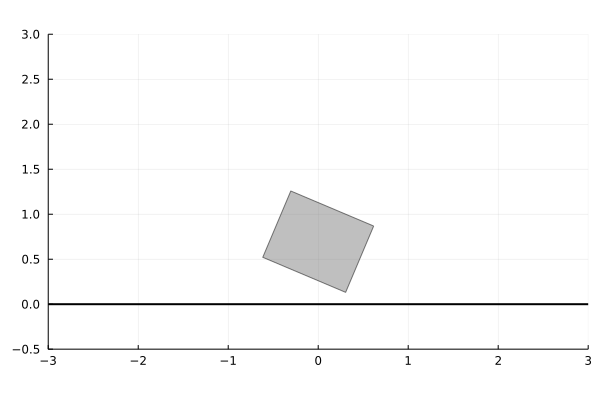

In [143]:
gif(anim, "anim.gif", fps = Int(floor(n/tspan[2])))